In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [10]:
%matplotlib inline

from sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from scipy import stats
from scipy import signal
from matplotlib.lines import Line2D
from sklearn import decomposition
from population import unit_activity_matrix
from psth import get_psth_matrix
from spiketrain import get_shuffled
from events import get_event_periods
from psth import staple_pulsetrain, staple_spike_times
from neurosuite import get_unit_names_sorted

import itertools, json

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [12]:
def make_smooth(data, k_width=25):  # k_width sampled as sound events
    kernel  = signal.gaussian(k_width, std=(k_width) / 7.2)
    return np.convolve(data, kernel, 'same') / kernel.sum()

In [101]:
def get_conf_intervals(data):
    conf_low  = np.zeros(data.shape[1])
    conf_high = np.zeros(data.shape[1])
    for i, col in enumerate(data.T):
        conf_low[i]  = np.percentile(col, 5)
        conf_high[i] = np.percentile(col, 95)
        
    return conf_low, conf_high

In [14]:
nMAP_electrodes = {
    '009265': [1, 2],
    '009266': [1, 2],
    '57': [1],
    '60': [1, 2]
}

In [16]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

# manuscript session
# '009266_hippoSIT_2023-04-18_10-10-37'

all_selected = selected_009266 + selected_009265 + selected_57
#selected = all_selected[:]
selected = all_selected
selected.remove('009265_hippoSIT_2023-03-05_18-31-32')
selected.remove('57_SIT_2023-12-29_12-11-46')
#selected.remove('009265_hippoSIT_2023-03-05_18-31-32')

#selected = selected_009266
#session = selected[8]
#session
selected[:3]

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10']

## Evoked

In [97]:
bin_size = 0.01
comp_count = 10  # PCA components
event_id = 1  # BGR only
conditions = {-1: 'NOI', 0: 'SIL', 1: 'BGR', 2: 'TGT'}

var_exp_real = np.zeros([len(selected), comp_count])
var_exp_shuf = np.zeros([len(selected), comp_count])
corrs_real_all = []
corrs_shuf_all = []

for i, session in enumerate(selected):
    # read datasets
    animal    = session.split('_')[0]
    s_path    = os.path.join(source, animal, session)
    meta_file = os.path.join(s_path, 'meta.h5')
    unit_file = os.path.join(s_path, 'units.h5')
    psth_file = os.path.join(s_path, 'analysis', 'psth_micro.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        sound_events = np.array(f['processed']['sound_events'])
        cfg = json.loads(f['processed'].attrs['parameters'])
    
    latency  = cfg['sound']['latency']  # seconds
    bins_per_event = int(latency / bin_size)
    electrodes = nMAP_electrodes[animal]
    bins_ev, unit_mx_real = unit_activity_matrix(meta_file, unit_file, electrodes, bin_size=bin_size)
    bins_ev, unit_mx_shuf = unit_activity_matrix(meta_file, unit_file, electrodes, bin_size=bin_size, shuffle=True)

    if unit_mx_real.shape[0] < comp_count:
        continue
        
    # response profile matrix
    psth_bins, psths_all = get_psth_matrix(psth_file, electrodes)
    
    # taking only the evoked profile part (important - this is not periodic!)
    idx_s = int(psth_bins.shape[0]/2)
    idx_e = idx_s + int(np.ceil(idx_s/2))
    ev_bin_count = idx_e - idx_s

    # which sound pulses to consider
    idxs_cond = np.where(sound_events[:, 1] == event_id)[0] * bins_per_event

    def get_CCR_mx(unit_mx):  # hack, sorry
        # hstack evoked parts of selected sound condition
        unit_mx_filt = unit_mx[:, idxs_cond[0]:idxs_cond[0] + ev_bin_count]
        for idx in idxs_cond[1:]:
            unit_mx_filt = np.hstack([unit_mx_filt, unit_mx[:, idx:idx + ev_bin_count]])

        assert unit_mx_filt.shape[1] == ev_bin_count * len(idxs_cond)

        # z-score already reduced matrix
        for j in range(len(unit_mx_filt)):
            unit_mx_filt[j] = stats.zscore(unit_mx_filt[j])

        # compute CCR matrix
        CCR_mx = np.zeros(unit_mx_filt.shape)
        for unit_idx in range(unit_mx_filt.shape[0]):
            prof = psths_all[conditions[event_id]][:, idx_s:idx_e][unit_idx]  # evoked part only!
            spks = unit_mx_filt[unit_idx]
            CCR_mx[unit_idx] = signal.correlate(spks, prof, mode='same')
        
        return CCR_mx, unit_mx_filt
    
    CCR_mx_real, unit_mx_filt_real = get_CCR_mx(unit_mx_real)
    CCR_mx_shuf, unit_mx_filt_shuf = get_CCR_mx(unit_mx_shuf)
    
    pca_real = decomposition.PCA(n_components=comp_count)
    X_real   = pca_real.fit_transform(CCR_mx_real.T)
    pca_shuf = decomposition.PCA(n_components=comp_count)
    X_shuf   = pca_shuf.fit_transform(unit_mx_filt_shuf.T)
    
    var_exp_real[i] = pca_real.explained_variance_ratio_
    var_exp_shuf[i] = pca_shuf.explained_variance_ratio_
    
    print('\rSession %s done' % session[-19:-6], end='')

Session 2024-01-15_14 done

In [98]:
not_enough = len([x for x in var_exp_real if (x == 0).all()])
print("Enough units: %d, not enough: %d" % (len(selected) - not_enough, not_enough))

Enough units: 40, not enough: 14


In [99]:
# remove rows with not enough units
var_exp_real = var_exp_real[~np.all(var_exp_real == 0, axis=1)]
var_exp_shuf = var_exp_shuf[~np.all(var_exp_shuf == 0, axis=1)]

## PCA

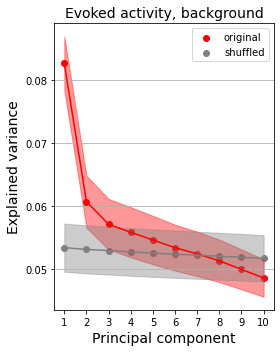

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(4, 5))

x_vals = (np.arange(comp_count) + 1).astype(np.int32)
conf_low_real, conf_high_real = get_conf_intervals(var_exp_real)
conf_low_shuf, conf_high_shuf = get_conf_intervals(var_exp_shuf)
verm = var_exp_real.mean(axis=0)
vesm = var_exp_shuf.mean(axis=0)
sem_real = stats.sem(var_exp_real)
sem_shuf = stats.sem(var_exp_shuf)

ax.plot(x_vals, var_exp_real.mean(axis=0), color='red')
ax.plot(x_vals, var_exp_shuf.mean(axis=0), color='grey')
ax.scatter(x_vals, var_exp_real.mean(axis=0), color='red', label='original')
ax.scatter(x_vals, var_exp_shuf.mean(axis=0), color='grey', label='shuffled')

# sems
ax.fill_between(x_vals, verm - sem_real, verm + sem_real, color='red', alpha=0.4)
ax.fill_between(x_vals, vesm - sem_shuf, vesm + sem_shuf, color='grey', alpha=0.4)

# 5 - 95 conf intervals
#ax.fill_between(x_vals, conf_low_real, conf_high_real, color='red', alpha=0.4)
#ax.fill_between(x_vals, conf_low_shuf, conf_high_shuf, color='grey', alpha=0.4)
#ax.set_ylim(0, 0.15)

ax.grid(axis='y')
ax.set_xticks(x_vals)
ax.set_xticklabels(x_vals, fontsize=10)
ax.set_xlabel('Principal component', fontsize=14)
ax.set_ylabel('Explained variance', fontsize=14)
ax.set_title('Evoked activity, background', fontsize=14)
ax.legend()

fig.tight_layout()

In [104]:
fig.savefig(os.path.join(rep_path, 'PCA_unit_mx_evoked.png'), dpi=300)